# PART 2 - Text summarization 

In this part I will try to summarize text sematics from the news. I will use for Y - title column. 

For this task I have to create Encoder-Decoder model where the input are text and the title and target is going to be the same title column but reshaped one. 


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import os
from collections import defaultdict

from wordcloud import WordCloud, STOPWORDS , ImageColorGenerator
import re
import nltk as nlp
import math
from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.translate.bleu_score import sentence_bleu

import tensorflow as tf 


In [3]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Embedding, Dense, SimpleRNN, LSTM, Bidirectional, GlobalAveragePooling1D, Dropout, Attention, TimeDistributed, Concatenate
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from tensorflow.keras.regularizers import l1_l2

import tensorflow_hub as hub

In [136]:
from transformers import TFBertModel, BertTokenizer, BertConfig, pipeline

In [7]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)
print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

1 Physical GPUs, 1 Logical GPUs
Version:  2.4.1
Eager mode:  True
Hub version:  0.11.0
GPU is available


# Import data 

I am going to use the same data as Part One.

In [8]:
train = pd.read_csv("output_datasets/news_output/train_data.csv")
val = pd.read_csv("output_datasets/news_output/val_data.csv")
test = pd.read_csv("output_datasets/news_output/test_data.csv")

## Cleaning text

I will perform basic text cleaning for both text and title because we need to get rid of symbols, single chars and lower the text. 
Also I don't want to Lemmatize the words becasue I will prefer them to be as they are.

In [10]:
def denoise_text(text):

    text = re.sub(r"[<>()|&©ø\[\]\'\",;?~*!]", ' ', str(text)).lower() #remove <>()|&©ø"',;?~*!
    text = re.sub("(\s+.\s+)", ' ', str(text)).lower()
    
    text = re.sub("(\s+)",' ',str(text)).lower() #remove multiple spaces
        
        #Should always be last
    text = re.sub("(\s+.\s+)", ' ', str(text)).lower() #remove any single charecters hanging between 2 spaces
    
    return text

In [11]:
train['cleaned_text'] = train.text.apply(denoise_text)
train['cleaned_title'] = train.title.apply(denoise_text)

val['cleaned_text'] = val.text.apply(denoise_text)
val['cleaned_title'] = val.title.apply(denoise_text)

test['cleaned_text'] = test.text.apply(denoise_text)
test['cleaned_title'] = test.title.apply(denoise_text)


With next cell I am going to append to each Title row in the begining [_START_] and in the end [_END__] because we will need that for the Inference phase.

In [12]:
train_summary = ['_START_ '+ str(doc) + ' _END_' for doc in train.cleaned_title]
val_summary = ['_START_ '+ str(doc) + ' _END_' for doc in val.cleaned_title]
test_summary = ['_START_ '+ str(doc) + ' _END_' for doc in test.cleaned_title]


In [13]:
train.cleaned_title = pd.Series(train_summary)
val.cleaned_title = pd.Series(val_summary)
test.cleaned_title = pd.Series(test_summary)


In [14]:
#Check how much % of title have 0-15 words
cnt=0
for i in train['cleaned_title']:
    if(len(i.split())<=15):
        cnt=cnt+1
print(cnt/len(train['cleaned_title']))

0.9769166666666667


In [15]:
#Check how much % of text have 0-40 words
cnt=0
for i in train['cleaned_text']:
    if(len(i.split())<=45):
        cnt=cnt+1
print(cnt/len(train['cleaned_text']))

0.9506354166666666


In [16]:
val.shape, test.shape, train.shape

((12000, 5), (19600, 5), (96000, 5))

So we have cleaned our data and also we chose constants for maximum text (news) length and the title

## TOEKNIZING

I am going to use tensorflow Tokenizer and tokenize both text and title columns.

In [17]:
#Model to summarize the text between 0-15 words for Summary and 0-40 words for Text
MAX_TEXT_LEN = 40
MAX_SUMMARY_LEN = 15

##### Text tokenizer - we are going to store tokenizer and word for the text

In [18]:
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(train.cleaned_text))

In [19]:
def tokenize_text(df, tokenizer):

    x_seq = tokenizer.texts_to_sequences(df.cleaned_text)
    x_tr = pad_sequences(x_seq, maxlen=MAX_TEXT_LEN, padding= "post")
    
    return x_tr
    

In [20]:
X_VOC = len(x_tokenizer.word_index) + 1 ## beacuse of the padding

In [21]:
X_tr = tokenize_text(train, x_tokenizer)
X_val = tokenize_text(val, x_tokenizer)
X_test = tokenize_text(test, x_tokenizer)


In [22]:
X_tr.shape, X_val.shape, X_test.shape

((96000, 40), (12000, 40), (19600, 40))

##### Title tokenizer - we are going to store tokenizer and word for the title

In [23]:
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(train.cleaned_title))

In [24]:
def tokenize_title(df, tokenizer):

    y_seq = tokenizer.texts_to_sequences(df.cleaned_title)
    y_tr = pad_sequences(y_seq, maxlen=MAX_SUMMARY_LEN, padding= "post")
    
    return y_tr
    

In [25]:
Y_VOC = len(y_tokenizer.word_index) + 1 ## beacuse of the padding

In [26]:
Y_tr = tokenize_title(train, y_tokenizer)
Y_val = tokenize_title(val, y_tokenizer)
Y_test = tokenize_title(test, y_tokenizer)


In [27]:
Y_tr.shape, Y_val.shape, Y_test.shape

((96000, 15), (12000, 15), (19600, 15))

In [28]:
X_VOC, Y_VOC

(56175, 30934)

X_VOC and Y_VOC contains number of words + 1 for the padding. We will need them in the model as a constants.

## MODEL BUILDING
### Basic LSTM Encoder - Decoder

I am going to create Encoder Decoder model using LSTM cells fot their ability to keep the long term memory

In [29]:
latent_dim = 100 ## lstm uinits
embedding_dim = 100 ## for the emmbeding layer

In [30]:
def build_basic_seq2seq_model(embedding_dim, latent_dim, MAX_TEXT_LEN, X_VOC, Y_VOC):
   
      ## ENCODER

      encoder_input = Input(shape=(MAX_TEXT_LEN,))

      # encoder embedding layer
      encoder_embedding = Embedding(X_VOC, embedding_dim, trainable=True)(encoder_input)

      # encoder lstm 1
      encoder_lstm1 = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.55)
      encoder_output1, state_h1, state_c1 = encoder_lstm1(encoder_embedding)

      # encoder lstm 2
      encoder_lstm2 = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.55)
      encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

      #encoder lstm 3
      encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.55)
      encoder_output, *encoder_final_states = encoder_lstm3(encoder_output2)


      # DECODER

      decoder_input = Input(shape=(None,))

      # decoder embedding layer
      decoder_embedding_layer = Embedding(Y_VOC, embedding_dim, trainable=True)
      decoder_embedding = decoder_embedding_layer(decoder_input)

      # decoder lstm 1
      decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.55)
      decoder_output, *decoder_final_states = decoder_lstm(decoder_embedding, initial_state=encoder_final_states)

      # dense layer
      decoder_dense = TimeDistributed(Dense(Y_VOC, activation='softmax'))
      decoder_output = decoder_dense(decoder_output)


      model = Model([encoder_input, decoder_input], decoder_output)
      model.summary()


      optimizer = tf.keras.optimizers.Adam(learning_rate=0.002)
      model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy')

      return {
          'model': model,
          'inputs': {
              'encoder': encoder_input,
              'decoder': decoder_input
          },
          'outputs': {
              'encoder': encoder_output,
              'decoder': decoder_output
          },
          'states': {
              'encoder': encoder_final_states,
              'decoder': decoder_final_states
          },
          'layers': {
              'decoder': {
                  'embedding': decoder_embedding_layer,
                  'last_decoder_lstm': decoder_lstm,
                  'dense': decoder_dense
              }
          }
        }

With those returns I am going to buld another consrtuction of the model for the generating phase

In [31]:
seq2seq = build_basic_seq2seq_model(embedding_dim = embedding_dim, latent_dim=latent_dim, MAX_TEXT_LEN=MAX_TEXT_LEN, X_VOC=X_VOC, Y_VOC=Y_VOC)

model = seq2seq['model']

## we are getting the element like that so in the inferense stage (where we are building new model) is going to be easier for us to buld 
encoder_input_mod = seq2seq['inputs']['encoder']
decoder_input_mod = seq2seq['inputs']['decoder']

encoder_output_mod = seq2seq['outputs']['encoder']
decoder_output_mod = seq2seq['outputs']['decoder']

encoder_final_states_mod = seq2seq['states']['encoder']
decoder_final_states_mod = seq2seq['states']['decoder']

decoder_embedding_layer_mod = seq2seq['layers']['decoder']['embedding']
last_decoder_lstm_mod = seq2seq['layers']['decoder']['last_decoder_lstm']
decoder_dense_mod = seq2seq['layers']['decoder']['dense']

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 40, 100)      5617500     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 40, 100), (N 80400       embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [32]:
model.load_weights("Part_two/seq2seq/seq2seq.h5")

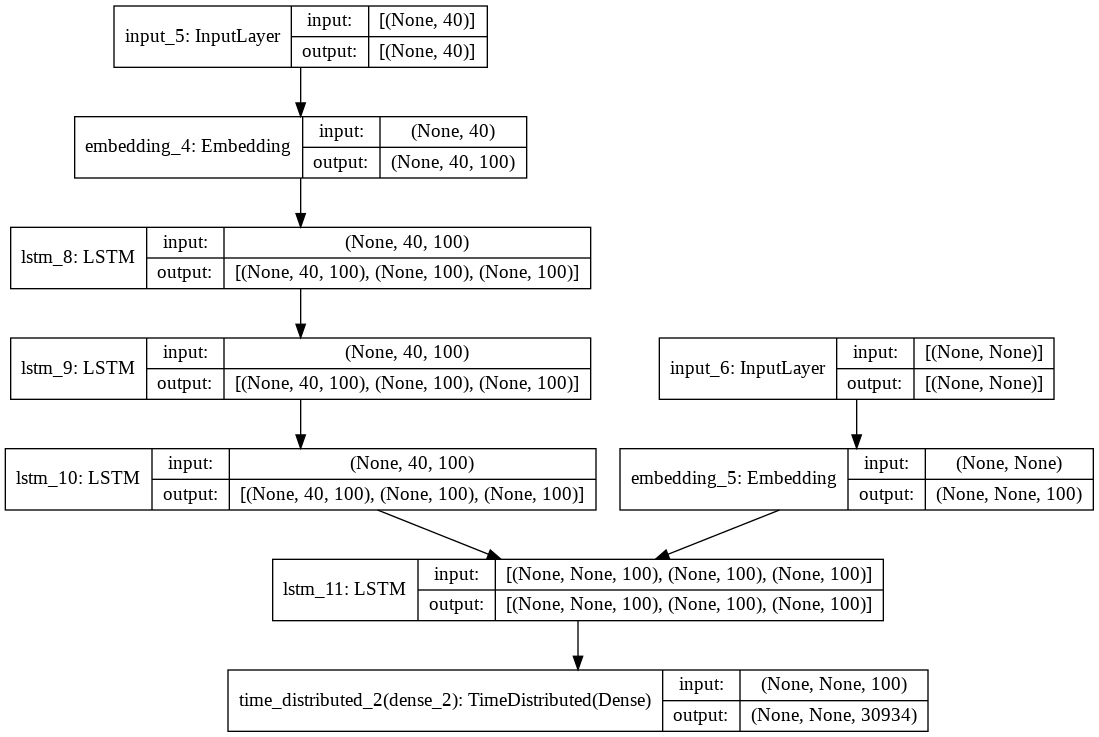

In [ ]:
plot_model(model, show_shapes=True)

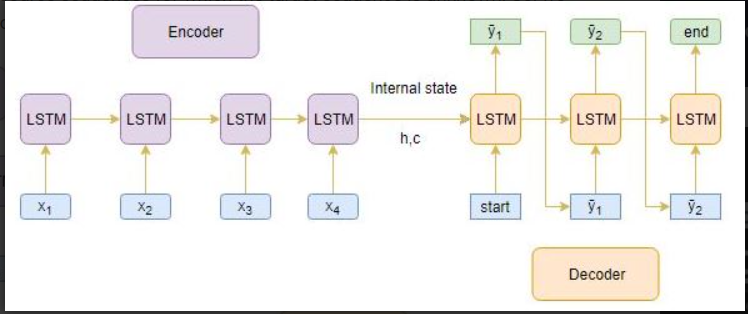

Here is our model. We have input for the Text column where we have established 3 LSTM cells. We pass to each sequences and the states where we use the long term memmory. The hidden state (hi) and cell state (ci) of the last time step are used to initialize the decoder. 

For each timestep in the **Encoder** one word from the text is being passed whit that it captures the contextual information in the input sequences. 

From the right side we have the Title input - **Decoder**. Also we have the Embedding layer for them.
The Decoder also reads word by word the target and predicts the same sequence data by one timestep. Also is trained to predict the next word in the sequence given the prvious word.
The _START_ and _END_ tokens are special ones which are added to target sequence.
The target sequence is unknown while decoding the test sequence. So, we start predicting the target sequence by passing the first word into the decoder which would be always the _START_ token. And the _END_ token signals the end of the sentence.


Training the model:

In [ ]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=1,
    min_lr=0.000001,
    verbose=1
)

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.002), loss='sparse_categorical_crossentropy')

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
mc = ModelCheckpoint(filepath='model_basic.h5',
                                        monitor='val_loss', 
                                        mode='min', 
                                        save_best_only=True,
                                        save_weights_only=True,
                                        verbose=1)

In [ ]:
model_history=model.fit([X_tr, Y_tr[:,:-1]], Y_tr.reshape(Y_tr.shape[0], Y_tr.shape[1], 1)[:,1:],
                                    epochs=30, callbacks=[es, mc, reduce_lr], batch_size=1024,
                                   validation_data=([X_val, Y_val[:,:-1]], Y_val.reshape(Y_val.shape[0], Y_val.shape[1], 1)[:,1:]))

Epoch 1/30
94/94 [==============================] - 59s 625ms/step - loss: 5.7568 - val_loss: 4.3981

Epoch 00001: val_loss improved from inf to 4.39808, saving model to model_basic.h5
Epoch 2/30
94/94 [==============================] - 58s 617ms/step - loss: 4.2866 - val_loss: 4.0468

Epoch 00002: val_loss improved from 4.39808 to 4.04680, saving model to model_basic.h5
Epoch 3/30
94/94 [==============================] - 58s 619ms/step - loss: 4.0685 - val_loss: 3.9236

Epoch 00003: val_loss improved from 4.04680 to 3.92357, saving model to model_basic.h5
Epoch 4/30
94/94 [==============================] - 58s 622ms/step - loss: 3.9669 - val_loss: 3.8556

Epoch 00004: val_loss improved from 3.92357 to 3.85555, saving model to model_basic.h5
Epoch 5/30
94/94 [==============================] - 59s 625ms/step - loss: 3.9006 - val_loss: 3.8083

Epoch 00005: val_loss improved from 3.85555 to 3.80834, saving model to model_basic.h5
Epoch 6/30
94/94 [==============================] - 59s 627

In [ ]:
model.evaluate([X_test, Y_test[:,:-1]], Y_test.reshape(Y_test.shape[0], Y_test.shape[1], 1)[:,1:])

613/613 [==============================] - 24s 28ms/step - loss: 3.1761


3.1431186199188232

In [ ]:
model.save("/content/summ_model")

INFO:tensorflow:Assets written to: /content/summ_model/assets


INFO:tensorflow:Assets written to: /content/summ_model/assets


In [ ]:
model.save_weights("/content/summ_model/seq2seq.h5")

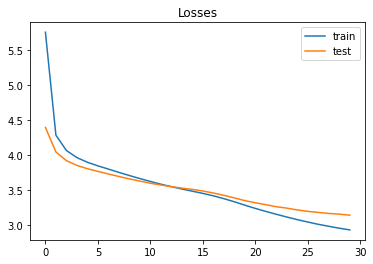

In [ ]:
plt.title("Losses")
plt.plot(model_history.history['loss'], label='train')
plt.plot(model_history.history['val_loss'], label='test')
plt.legend()
plt.show()

After a lot of attempts those results were the best of what i got with this architecture and that data. 

#### INFERENCE PHASE

After training, the model is tested on new source sequences for which the target sequence is unknown. So, we need to set up the inference architecture to decode a test sequence:

How does the inference process work?

Here are the steps to decode the test sequence:

    1) Encode the entire input sequence and initialize the decoder with internal states of the encoder
    
    2) Pass <start> token as an input to the decoder
    
    3) Run the decoder for one timestep with the internal states
        
    4) The output will be the probability for the next word. The word with the maximum probability will be selected
    
    5) Pass the sampled word as an input to the decoder in the next timestep and update the internal states with the current time step
    
    6) Repeat steps 3 – 5 until we generate <end> token or hit the maximum length of the target sequence
   
Let’s take an example where the test sequence is given by  [x1, x2, x3, x4]. How will the inference process work for this test sequence? I want you to think about it before you look at my thoughts below.

    Encode the test sequence into internal state vectors
    Observe how the decoder predicts the target sequence at each timestep:


In [33]:
# saving key-values for each word from both tokenizers
reverse_target_word_index=y_tokenizer.index_word  
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [35]:
len(reverse_target_word_index)

30933

We are going to create out inference model from our previous  with saved weights. 

In [36]:
def build_basic_seq2seq_model_inference(
    MAX_TEXT_LEN, latent_dim,
    encoder_input, encoder_output, encoder_final_states,
    decoder_input, decoder_output, 
    decoder_embedding_layer, decoder_dense, last_decoder_lstm
):
    # Encode the input sequence to get the feature vector
    encoder_model = Model(inputs=encoder_input, outputs=[encoder_output] + encoder_final_states)
    
    # Decoder setup
    # Below tensors will hold the states of the previous time step
    decoder_state_input_h = Input(shape=(latent_dim,))
    decoder_state_input_c = Input(shape=(latent_dim,))
    decoder_hidden_state_input = Input(shape=(MAX_TEXT_LEN, latent_dim))
    
    # Get the embeddings of the decoder sequence
    decoder_embedding = decoder_embedding_layer(decoder_input)
    
    # To predict the next word in the sequence, set the initial
    # states to the states from the previous time step
    decoder_output, *decoder_states = last_decoder_lstm(
        decoder_embedding, initial_state=[decoder_state_input_h, decoder_state_input_c]
    )
    
    # A dense softmax layer to generate prob dist. over the target vocabulary
    decoder_output = decoder_dense(decoder_output)
    
    # Final decoder model
    decoder_model = Model(
        [decoder_input] + [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c],
        [decoder_output] + decoder_states
    )
    
    return (encoder_model, decoder_model)


In [37]:
encoder_model, decoder_model = build_basic_seq2seq_model_inference(MAX_TEXT_LEN, latent_dim, encoder_input_mod,
                                                                   encoder_output_mod, encoder_final_states_mod, decoder_input_mod, decoder_output_mod,
                                                                   decoder_embedding_layer_mod, decoder_dense_mod, last_decoder_lstm_mod)

**ENCODER MODEL** - We get from the firs model parts with the weight and build new models for the INFERENCE PHASE

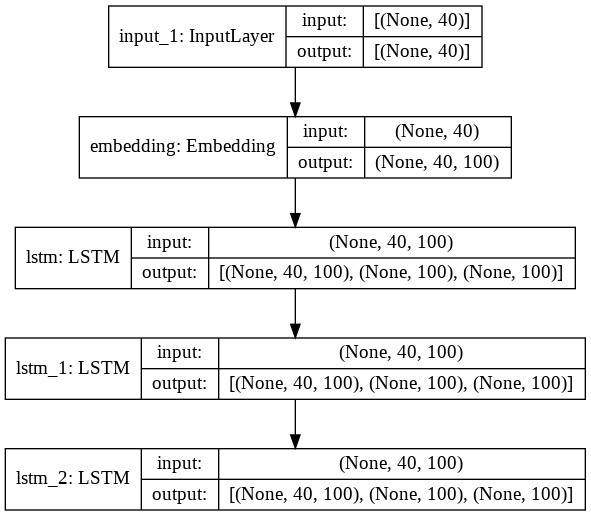

In [38]:
plot_model(encoder_model, show_shapes=True)

**Decoder Model ** this is for generating the title for the news text part

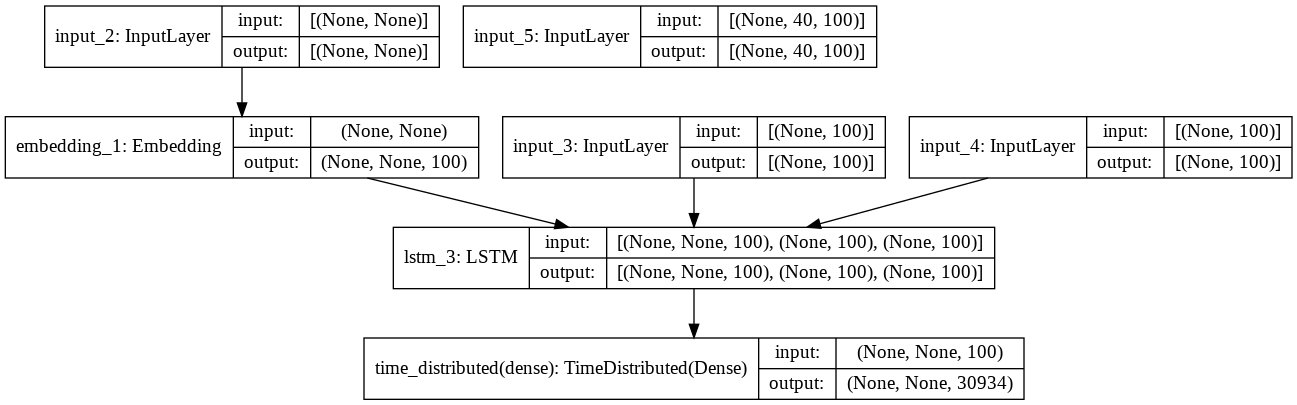

In [ ]:
plot_model(decoder_model, show_shapes=True)

With the next functuon I am going to decode the predictions for the words of the title column.

In [45]:
def decode_sequence_for_basic_seq2seq_model(input_sequence, encoder_model, decoder_model):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_sequence)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1))

    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index["start"]

    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[int(sampled_token_index)]

        if sampled_token != "end":
            decoded_sentence += ' ' + sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == "end") or (len(decoded_sentence.split()) >= (MAX_SUMMARY_LEN-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c


    return decoded_sentence

Whith those functions I will translate from tokenized to normal text:

In [46]:
def seq2summary(input_sequence):
    new_string = ''
    for i in input_sequence:
        if((i != 0 and i != target_word_index["start"]) and (i != target_word_index["end"])):
            new_string = new_string + reverse_target_word_index[i] + ' '
    return new_string


def seq2text(input_sequence):
    new_string = ''
    for i in input_sequence:
        if i != 0:
            new_string = new_string + reverse_source_word_index[i] + ' '
    return new_string

In [47]:
for i in range(0, 40):
    print(f"# {i+1} News: ", seq2text(X_test[i]))
    print("Original summary: ", seq2summary(Y_test[i]))
    print("Predicted summary: ", decode_sequence_for_basic_seq2seq_model(X_test[i].reshape(1, MAX_TEXT_LEN), encoder_model, decoder_model))
    print()
    

# 1 News:  new warning added in march appeared to have little impact on children use of the drugs children aged to 17 still account for percent of anti prescribed said michael evans of the food and drug administration office of drug safety 
Original summary:  fda eyes rules on child anti depressants 
Predicted summary:   bush kerry to be sold for the tax

# 2 News:  author jk rowling gives fans brief preview of the next harry potter novel it is reported 
Original summary:  fans given potter book preview 
Predicted summary:   the the the game

# 3 News:  baghdad iraq decapitated body wrapped in an american flag and found in an insurgent controlled section of baghdad was that of japanese man kidnapped by islamic militants japanese official said sunday 
Original summary:  japan says decapitated body is that of kidnapped tourist 
Predicted summary:   us soldier killed in iraq

# 4 News:  iranian president mohammad khatami has criticised an international atomic energy agency resolution on i

In general I am using argmax function, that is greedy algorithm that takes only the word with highest possibility.

To make it better Beam Search will be better choice.

In [ ]:
tf.keras.backend.clear_session()

### BERT Encoder and Decoder

Now again I want to use Bert for this task. Basically BERT is part of Transformer (only the encoder). 
BERT makes use of Transformer, an attention mechanism that learns contextual relations between words (or sub-words) in a text. Transformer includes two separate mechanisms — an encoder that reads the text input and a decoder that produces a prediction for the task. Since BERT’s goal is to generate a language model, only the encoder mechanism is necessary. 

Nut can we implement BERT functionality for this task? BERT has 12 self-attention layers, that means that we have the output and the attentions for the previous layers.

In [56]:
#Model to summarize the text between 0-15 words for Summary and 0-100 words for Text
MAX_TEXT_LEN = 40
MAX_SUMMARY_LEN = 15

#### Text preprocessing and tokenizing

In [57]:
train.text = train.text.apply(denoise_text)
train.title = train.title.apply(denoise_text)

val.text = train.text.apply(denoise_text)
val.title = train.title.apply(denoise_text)


Text tokenizing

using  BERT Toeknizer - with the usage of it we are going to have for BERT layer 3 inputs again

In [58]:
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [59]:
title_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [60]:
bert = "bert-base-uncased"

In [61]:
config = BertConfig(dropout = 0.2, attention_dropout = 0.2)
config.output_attentions = True,
config.output_hidden_states = True


In [62]:
encoded_data_train = bert_tokenizer.batch_encode_plus(train.text, add_special_tokens=True, return_attention_mask=True,
                                 padding = True, max_length = MAX_TEXT_LEN, truncation = True, return_tensors = "tf")

encoded_data_val = bert_tokenizer.batch_encode_plus(val.text, add_special_tokens=True, return_attention_mask=True,
                                 padding = True, max_length = MAX_TEXT_LEN, truncation = True, return_tensors = "tf")

encoded_data_test = bert_tokenizer.batch_encode_plus(test.text, add_special_tokens=True, return_attention_mask=True,
                                 padding = True, max_length = MAX_TEXT_LEN, truncation = True, return_tensors = "tf")

In [63]:
X_VOC_BERT = bert_tokenizer.vocab_size + 1

In [64]:
train_input_ids = encoded_data_train['input_ids']
train_attention_mask = encoded_data_train['attention_mask']
train_token_type_ids = encoded_data_train['token_type_ids']


val_input_ids = encoded_data_val['input_ids']
val_attention_mask = encoded_data_val['attention_mask']
val_token_type_ids = encoded_data_val['token_type_ids']


test_input_ids = encoded_data_test['input_ids']
test_attention_mask = encoded_data_test['attention_mask']
test_token_type_ids = encoded_data_test['token_type_ids']

Title tokenizing

For that case I am going to use normal Tensorflow Tokenizer and also include both [_Start_] and [_End_] tokens

In [65]:
train['cleaned_title'] = pd.Series(['_START_ '+ str(doc) + ' _END_' for doc in train.title])
val['cleaned_title'] = pd.Series(['_START_ '+ str(doc) + ' _END_' for doc in val.title])
test['cleaned_title'] = pd.Series(['_START_ '+ str(doc) + ' _END_' for doc in test.title])


In [66]:
title_train = tokenize_title(train, y_tokenizer)
title_val = tokenize_title(val, y_tokenizer)
title_test = tokenize_title(test, y_tokenizer)


In [67]:
Y_VOC = len(y_tokenizer.word_index) + 1 ## beacuse of the padding

In [68]:
X_VOC_BERT, Y_VOC

(30523, 30934)

#### Building BERT model

In [69]:
def build_bert_model(embedding_dim, latent_dim, MAX_TEXT_LEN, X_VOC_BERT, Y_VOC, lr):
      
      ## ENCODER

      encoder_model = TFBertModel.from_pretrained(bert, config = config, trainable = False)

      input_ids = Input(shape=(MAX_TEXT_LEN,), name='input_ids', dtype='int32')
      attention_mask = Input(shape=(MAX_TEXT_LEN,), name='attention_mask', dtype='int32')
      token_type_ids = Input(shape=(MAX_TEXT_LEN,), name='token_type_ids', dtype='int32')

      # encoder embedding layer
      encoder_embedding = encoder_model([input_ids, attention_mask, token_type_ids])[0]

      # all_hidden_states = encoder_embedding[2]
      # attentions = encoder_embedding[3]

      # encoder lstm 1
      encoder_lstm1 = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.55, name = "encoder_lstm")
      encoder_output, *encoder_final_states = encoder_lstm1(encoder_embedding)

      # DECODER

      decoder_input = Input(shape=(None,))

      # decoder embedding layer
      decoder_embedding_layer = Embedding(Y_VOC, embedding_dim, trainable=True)
      decoder_embedding = decoder_embedding_layer(decoder_input)
      

      # decoder lstm 1
      decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.55, name = "decoder_lstm")
      decoder_output, *decoder_final_states = decoder_lstm(decoder_embedding, initial_state=encoder_final_states)

      # dense layer
      decoder_dense = TimeDistributed(Dense(Y_VOC, activation='softmax'))
      decoder_output = decoder_dense(decoder_output)


      model = Model([[input_ids, attention_mask, token_type_ids], decoder_input], decoder_output)


      model.summary()


      optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
      model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy')
    

      return {
          'model': model,
          'inputs': {
              'encoder': {
                        "input_ids": input_ids,
                        "attention_mask": attention_mask,
                        "token_type_ids": token_type_ids
              },
              'decoder': decoder_input
          },
          'outputs': {
              'encoder': encoder_output,
              'decoder': decoder_output
          },
          'states': {
              'encoder': encoder_final_states,
              'decoder': decoder_final_states
          },
          'layers': {
              'decoder': {
                  'embedding': decoder_embedding_layer,
                  'last_decoder_lstm': decoder_lstm,
                  'dense': decoder_dense
              }
          }
        }

In [70]:
bert_model_decod_encod = build_bert_model(100, 64, MAX_TEXT_LEN, X_VOC_BERT, Y_VOC, lr = 0.01)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experi

In [71]:
bert_decoder_encoder = bert_model_decod_encod['model']

In [72]:
bert_decoder_encoder.load_weights("/content/bert_Encoder_Decoder.h5")

In [73]:
encoder_inputs_ids = bert_model_decod_encod['inputs']['encoder']["input_ids"]
encoder_input_attention_mask = bert_model_decod_encod['inputs']['encoder']["attention_mask"]
encoder_input_token_type_ids = bert_model_decod_encod['inputs']['encoder']["token_type_ids"]
encoder_inputs = bert_model_decod_encod['inputs']['encoder']

decoder_input = bert_model_decod_encod['inputs']['decoder']

encoder_output = bert_model_decod_encod['outputs']['encoder']
decoder_output = bert_model_decod_encod['outputs']['decoder']

encoder_final_states = bert_model_decod_encod['states']['encoder']
decoder_final_states = bert_model_decod_encod['states']['decoder']

decoder_embedding_layer = bert_model_decod_encod['layers']['decoder']['embedding']
last_decoder_lstm = bert_model_decod_encod['layers']['decoder']['last_decoder_lstm']
decoder_dense = bert_model_decod_encod['layers']['decoder']['dense']

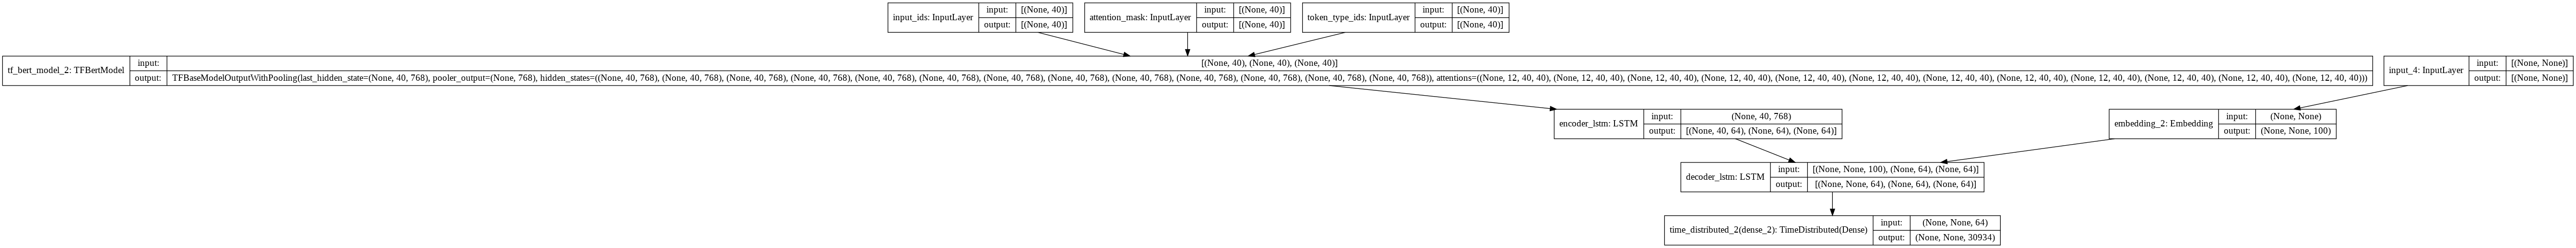

In [ ]:
plot_model(bert_decoder_encoder, show_shapes=True)

Depending on the configuration (BertConfig) and inputs, BertModel returns the following outputs;

    *last_hidden_state* — Sequence of hidden-states at the output of the last layer of the model.

    *pooler_output* — Last layer hidden-state of the first token of the sequence

    *hidden_states* (optional, returned when output_hidden_states=True is 
    passed or when config.output_hidden_states=True) – Hidden-states of the 
    model at the output of each layer plus the initial embedding outputs.

    *attentions* - (optional, returned when output_attentions=True is passed or 
    when config.output_attentions=True) – Attention weights after the attention 
    softmax used to compute the weighted average in the self-attention heads.


The full set of hidden states of the model, stored in the object hidden_states, is a little dizzying. This object has four dimensions, in the following order:
    The layer number (13 layers)

    The batch number (num of sentences)

    The word/token number (maximum length of sentences)

    The hidden unit/feature number (768 features)

Wait, 13 layers? Doesn’t BERT only have 12? It’s 13 because the first element is the input embeddings, the rest is the outputs of each of BERT’s 12 layers.

I connected BERT for one LSTM for Encoder part

In [ ]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=1,
    min_lr=0.000001,
    verbose=1
)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
mc = ModelCheckpoint(filepath='bert.h5',
                                        monitor='val_loss', 
                                        mode='min', 
                                        save_best_only=True,
                                        save_weights_only=True,
                                        verbose=1)

In [ ]:
hist_bert = bert_decoder_encoder.fit([[train_input_ids, train_attention_mask, train_token_type_ids], title_tain[:,:-1]], title_tain.reshape(title_tain.shape[0], title_tain.shape[1], 1)[:,1:],
                                    epochs=40, callbacks=[es, mc, reduce_lr], batch_size=1024,
                                   validation_data=([[val_input_ids, val_attention_mask, val_token_type_ids], title_val[:,:-1]], title_val.reshape(title_val.shape[0], title_val.shape[1], 1)[:,1:])

Epoch 1/40
94/94 [==============================] - 340s 4s/step - loss: 6.1100 - val_loss: 4.1755

Epoch 00001: val_loss improved from inf to 4.17550, saving model to bert.h5
Epoch 2/40
94/94 [==============================] - 328s 3s/step - loss: 3.9793 - val_loss: 3.8641

Epoch 00002: val_loss improved from 4.17550 to 3.86407, saving model to bert.h5
Epoch 3/40
94/94 [==============================] - 328s 3s/step - loss: 3.7513 - val_loss: 3.6676

Epoch 00003: val_loss improved from 3.86407 to 3.66756, saving model to bert.h5
Epoch 4/40
94/94 [==============================] - 328s 3s/step - loss: 3.5813 - val_loss: 3.5149

Epoch 00004: val_loss improved from 3.66756 to 3.51486, saving model to bert.h5
Epoch 5/40
94/94 [==============================] - 328s 3s/step - loss: 3.4509 - val_loss: 3.3831

Epoch 00005: val_loss improved from 3.51486 to 3.38315, saving model to bert.h5
Epoch 6/40
94/94 [==============================] - 328s 3s/step - loss: 3.3229 - val_loss: 3.2480

Epoc

In [ ]:
bert_decoder_encoder.save_weights("/content/bert_Encoder_Decoder.h5")


In [ ]:
bert_decoder_encoder.load_weights("/content/bert_Encoder_Decoder.h5")

In [ ]:
bert_decoder_encoder.evaluate([[test_input_ids, test_attention_mask, test_token_type_ids], title_test[:,:-1]], title_test.reshape(title_test.shape[0], title_test.shape[1], 1)[:,1:])

613/613 [==============================] - 107s 172ms/step - loss: 3.0953


3.064260482788086

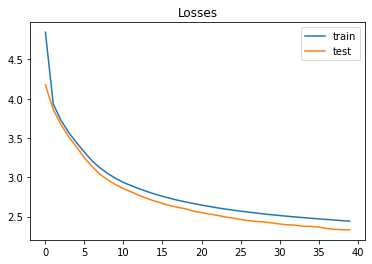

In [ ]:
plt.title("Losses")
plt.plot(hist_bert.history['loss'], label='train')
plt.plot(hist_bert.history['val_loss'], label='test')
plt.legend()
plt.show()

We can see this time we have better results for the loss and bearly overfiting

In [74]:
def build_basic_seq2seq_model_inference_with_bert(
    MAX_TEXT_LEN, latent_dim,
    encoder_input, encoder_output, encoder_final_states,
    decoder_input, decoder_output, 
    decoder_embedding_layer, decoder_dense, last_decoder_lstm
):
    # Encode the input sequence to get the feature vector
    encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_output] + encoder_final_states)
    
    # Decoder setup
    # Below tensors will hold the states of the previous time step
    decoder_state_input_h = Input(shape=(latent_dim,), name="input_h")
    decoder_state_input_c = Input(shape=(latent_dim,), name="input_c")
    decoder_hidden_state_input = Input(shape=(MAX_TEXT_LEN, latent_dim))
    
    # Get the embeddings of the decoder sequence
    decoder_embedding = decoder_embedding_layer(decoder_input)
    
    # To predict the next word in the sequence, set the initial
    # states to the states from the previous time step
    decoder_output, *decoder_states = last_decoder_lstm(
        decoder_embedding, initial_state=[decoder_state_input_h, decoder_state_input_c]
    )
    
    # A dense softmax layer to generate prob dist. over the target vocabulary
    decoder_output = decoder_dense(decoder_output)
    
    # Final decoder model
    decoder_model = Model(
        [decoder_input] + [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c],
        [decoder_output] + decoder_states
    )
    
    return (encoder_model, decoder_model)

In [75]:
encoder_model_bert, decoder_model_bert = build_basic_seq2seq_model_inference_with_bert(MAX_TEXT_LEN, 64, encoder_inputs,
                                                                   encoder_output, encoder_final_states, decoder_input, decoder_output,
                                                                   decoder_embedding_layer, decoder_dense, last_decoder_lstm)

In [76]:
reverse_target_word_index=y_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [77]:
def seq2summary(input_sequence):
    new_string = ''
    for i in input_sequence:
        if((i != 0 and i != target_word_index["start"]) and (i != target_word_index["end"])):
            new_string = new_string + reverse_target_word_index[i] + ' '
    return new_string


def seq2text(input_sequence):
    new_string = ''
    for i in input_sequence:
        if (i != 0 and i != 101) and (i != 102):
            new_string = new_string + bert_tokenizer.decode([i]) + ' '
    return new_string

In [78]:
for i in range(0, 20):
    print(f"# {i+1} News: ", seq2text(val_input_ids[i]))
    print("Original summary: ", seq2summary(title_val[i]))
    print("Predicted summary: ", decode_sequence_for_basic_seq2seq_model([val_input_ids[i].numpy().reshape(1, MAX_TEXT_LEN), val_attention_mask[i].numpy().reshape(1, MAX_TEXT_LEN),
                                                                          val_token_type_ids[i].numpy().reshape(1, MAX_TEXT_LEN)], encoder_model_bert, decoder_model_bert))
    print()

# 1 News:  the ioc wants suspended olympic member ivan sl ##av ##kov to be thrown out of the organisation . 
Original summary:  ioc recommends slavkov expulsion 
Predicted summary:   no oklahoma state defeats unlv in bcs standings

# 2 News:  reuters when india play pakistan it is classic hockey match their historic rivalry sucking in the whole stadium . 
Original summary:  hockey teams seek foreign secrets of success reuters 
Predicted summary:   radcliffe wins women 39

# 3 News:  secretary of state colin l . powell said yesterday that brazil is quo ##t serious quo ##t and quo ##t solid quo ##t candidate for permanent seat in an expanded un security council although 
Original summary:  bid for un seat 39 solid 39 powell says 
Predicted summary:   hurricane ivan churns toward caribbean isles

# 4 News:  russian president vladimir putin says his country is developing new type of nuclear missile . mr . putin spoke at an annual meeting of the armed forces # 39 senior leadership . 
Origin

In [ ]:
tf.keras.backend.clear_session()

We can see that we don't have the exact same output as the title. 
For better performance we can make further researches bulding a BERT (as encoder) and Transformer XL (as decoder). Using Beam search or try with pointer generator.

#### Another option with less coding and bulding bloacks: BART model

There is also fast pipeline provided by Huggingface, which can save you headaches dealing with hidden_states and connecting networks. It works quite well !

In [137]:
summarizer = pipeline('summarization')

In [142]:
for i in range(20):
  print(f"# {i+1} News: ", train.text[i])
  print("Original summary: ", train.title[i])
  print("Predicted summary: ", summarizer(train.text[i], max_length = MAX_SUMMARY_LEN, do_sample = False))
  print()

Your min_length is set to 56, but you input_length is only 24. You might consider decreasing min_length manually, e.g. summarizer('...', min_length=10)


# 1 News:  the ioc wants suspended olympic member ivan slavkov to be thrown out of the organisation.
Original summary:  ioc recommends slavkov expulsion


Your min_length is set to 56, but you input_length is only 25. You might consider decreasing min_length manually, e.g. summarizer('...', min_length=10)


Predicted summary:  [{'summary_text': ' ioc wants suspended olympic member ivan slav'}]

# 2 News:  reuters when india play pakistan it is classic hockey match their historic rivalry sucking in the whole stadium.
Original summary:  hockey teams seek foreign secrets of success reuters 
Predicted summary:  [{'summary_text': ' When india play pakistan it is classic hockey match'}]

# 3 News:  secretary of state colin l. powell said yesterday that brazil is quot serious quot and quot solid quot candidate for permanent seat in an expanded un security council although 
Original summary:  bid for un seat #39 solid #39 powell says
Predicted summary:  [{'summary_text': ' Secretary of State colin l. powell said yesterday that'}]

# 4 News:  russian president vladimir putin says his country is developing new type of nuclear missile. mr. putin spoke at an annual meeting of the armed forces #39 senior leadership.
Original summary:  putin: russia developing new kind of nuclear missile
Predicted summ

BART is Transformer with Encoder-Decoder Parts which is specialised for text summarization as well.